### **개요: 음식 재료의 사진을 업로드하면, 만들 수 있는 음식 메뉴를 추천해주고 레시피를 알려줍니다.**

In [1]:
!pip install openai==0.28
!pip install googletrans==4.0.0-rc1
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.0 MB/s eta 0:00:00
  Created wheel for googletran

In [2]:
import openai
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from google.colab import files
import requests
from PIL import Image
from keras.preprocessing import image
from IPython.display import display
from googletrans import Translator
from keras.applications.inception_v3 import decode_predictions
import ipywidgets as widgets
from io import BytesIO

In [3]:
'''
* openai_response(): Open AI 요청 함수
* parameter
* 1. prompt: 프롬프트 텍스트
'''
def openai_response(prompt):
    # OpenAI API 키 설정
    openai.api_key = 'hide_openai_key'
    # request
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=1500
    )
    # response text 리턴
    return response.choices[0].text.strip()

In [4]:
'''
* translate_name(): 음식 재료 이름을 영어 >> 한국어로 번역하는 함수
* parameter
* 1. english_name: 영어로 된 음식 재료 이름
'''
def translate_name(english_name):
  translator = Translator()
  return translator.translate(english_name, 'ko', 'en').text

In [5]:
# output class 정의
classes = ['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [6]:
'''
* get_menu(): 재료들로 만들 수 있는 음식 메뉴 추천 함수
* parameter
* 1. ingredients_name: 재료들의 이름 텍스트
'''
def get_menu(ingredients_name, food_category, user_level):
    # ChatGPT를 사용하여 메뉴 3개 추천하기
    prompt = f"{food_category}중에서 요리 실력이 {user_level}인 사용자가 {ingredients_name}로 요리할 수 있는 음식 메뉴 3개 단어를 ,로 띄워서 한줄로 알려줘"
    menu_response = openai_response(prompt)
    print(menu_response)

In [7]:
'''
* get_recipe(): 레시피 생성 및 출력 함수
* parameter
* 1. food_name: 레시피를 생성할 음식 이름
'''
def get_recipe(food_name):
    print(f"[ {food_name} 만드는 레시피 ]\n")
    recipe_response = "(1) 재료\n\n"

    # ChatGPT를 사용하여 레시피 알려주기
    prompt = f"{food_name} 만드는데 필요한 재료 알려줘"
    recipe_response += openai_response(prompt)

    recipe_response += "\n\n(2) 레시피\n\n"
    prompt = f"\n{food_name} 만드는 순서 알려줘"
    recipe_response += openai_response(prompt)
    print(recipe_response)

In [102]:
'''
* recognized_food(): 음식 재료 이미지 분류 함수
* parameter
* 1. images: {<food_name>:<food_content>} 형태의 Dictionary
'''
def recognized_food(images):
    # GitHub에 저장한 모델 파일 다운로드
    github_raw_url = 'https://raw.githubusercontent.com/milijung/MenuRecommendation_ChatBot/main/food_ingredient_recognition_model.pth'
    model_path = 'food_ingredient_recognition_model.pth'
    torch.hub.download_url_to_file(github_raw_url, model_path, progress=True)

    # 모델 로드
    model = torch.load(model_path, map_location=torch.device('cpu'))

    # 이미지 전처리 코드
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    food_name = ""

    for key in images.keys():
        file_content = images[key]

        # 파일 내용을 BytesIO로 읽음
        file_content_bytesio = BytesIO(file_content)

        # 이미지를 PIL Image로 변환
        input_image = Image.open(file_content_bytesio).resize((224, 224))
        display(input_image)

        # 이미지 전처리
        input_image = preprocess(input_image)
        input_image = input_image.unsqueeze(0)

        with torch.no_grad():
            model.eval()  # 모델을 평가 모드로 설정
            outputs = model(input_image)
            predictions = torch.nn.functional.softmax(outputs[0], dim=-1)

            # 예측 결과 디코딩 (top3)
            print()
            print("제가 예측한 이미지의 종류 Top3 입니다.")
            top3_probabilities, top3_classes = torch.topk(predictions, 3)
            for i in range(3):
              print(i+1,'->',translate_name(classes[top3_classes[i]]))

            print()
            print('3개의 후보 중에서, 이미지의 종류에 해당하는 번호를 선택해주세요.')
            food_idx = int(input("번호:"))
            print()

            food_name += translate_name(classes[top3_classes[food_idx-1]]) + ', '

    return food_name[:-2]

1. 사용자가 완성된 음식 재료 이미지들을 업로드하면, 객체 인식 AI가 어떤 음식재료 인지 인식합니다.

In [96]:
# 1. 음식 재료 이미지 업로드
print("안녕하세요! 가지고 있는 재료들을 찍어서 올려주세요.\n")

uploaded = files.upload()

안녕하세요! 가지고 있는 재료들을 찍어서 올려주세요.



Saving sample3.jpg to sample3 (2).jpg
Saving sample.jpg to sample (5).jpg


100%|██████████| 42.8M/42.8M [00:00<00:00, 195MB/s]


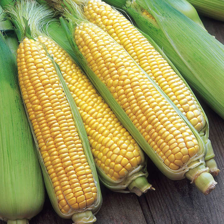


제가 예측한 이미지의 종류 Top3 입니다.
1 -> 레몬
2 -> 단 옥수수
3 -> 옥수수

3개의 후보 중에서, 이미지의 종류에 해당하는 번호를 선택해주세요.
번호:3



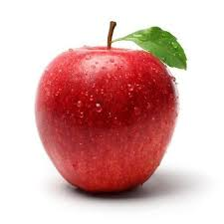


제가 예측한 이미지의 종류 Top3 입니다.
1 -> 레몬
2 -> 배
3 -> 사과

3개의 후보 중에서, 이미지의 종류에 해당하는 번호를 선택해주세요.
번호:3


현재 가지고 있는 재료: 옥수수, 사과


In [103]:
ingredients_name = ""

if len(uploaded) != 0:
  # 2. 음식 재료 이미지 인식
  ingredients_name = recognized_food(uploaded)
  # 3. 인식된 재료 이름 목록 출력
  print()
  print(f"현재 가지고 있는 재료: {ingredients_name}")

2. 원하는 음식의 메뉴 카테고리 정보를 입력합니다.

In [98]:
def on_change_category(change):
    global food_category
    if change['type'] == 'change' and change['name'] == 'value':
        print("선택된 옵션:", change['new'])
        food_category = change['new']

print('원하는 메뉴 카테고리를 선택해주세요 (Default: 한식)')
radiogroup_category = widgets.RadioButtons(
    options=['한식', '중식', '일식', '양식'],
    disabled=False
)

display(radiogroup_category)
radiogroup_category.observe(on_change_category)

food_category = radiogroup_category.value

원하는 메뉴 카테고리를 선택해주세요 (Default: 한식)


RadioButtons(options=('한식', '중식', '일식', '양식'), value='한식')

선택된 옵션: 중식


3. 사용자의 요리 실력 정보를 입력합니다.

In [99]:
def on_change_option(change):
    global user_level
    if change['type'] == 'change' and change['name'] == 'value':
        print("선택된 옵션:", change['new'])
        user_level = change['new']

print('사용자님의 요리 실력을 선택해주세요 (Default: 초급)')
radiogroup_userlevel = widgets.RadioButtons(
    options=['초급', '중급', '고급'],
    disabled=False
)

display(radiogroup_userlevel)
radiogroup_userlevel.observe(on_change_option)

user_level = radiogroup_userlevel.value

사용자님의 요리 실력을 선택해주세요 (Default: 초급)


RadioButtons(options=('초급', '중급', '고급'), value='초급')

선택된 옵션: 중급


4. Open AI의 API를 사용하여 해당 재료로 만들 수 있는 음식 메뉴를 3개 추천합니다.

In [100]:
if len(uploaded) != 0:
  print(f"해당 재료로 만들 수 있는 {food_category} 음식 메뉴는 다음과 같아요:\n")
  menu_list = get_menu(ingredients_name, food_category, user_level)

해당 재료로 만들 수 있는 중식 음식 메뉴는 다음과 같아요:

옥수수 스프, 사과 과자, 사과 빵


5. 사용자가 음식을 선택하면, Open AI의 API를 사용하여 요청한 음식의 레시피를 출력합니다.

In [101]:
food_name = input("레시피를 원하는 음식의 이름을 작성해주세요: ")

print()
get_recipe(food_name)

레시피를 원하는 음식의 이름을 작성해주세요: 옥수수 스프

[ 옥수수 스프 만드는 레시피 ]

(1) 재료

- 옥수수 : 300g
- 물 : 500ml
- 소금 : 약간
- 고춧가루 : 약간
- 물감 : 약간
- 기타 재료 : 소금, 고추, 물감 등

(2) 레시피

옥수수 스프 만드는 방법은 다음과 같습니다.

1. 옥수수를 깨끗이 씻어냅니다.

2. 옥수수를 설탕물에 담가 1시간가까이 담갔다가 달상에 넣습니다.

3. 달상에 담긴 옥수수를 스프 메이커에 넣고 스프를 끓인다.

4. 된 것을 다시한끼로 개략합니다.

5. 냄비에 끓인 물을 넣고 식혀 스프를 끓이면, 옥수수 스프가 완성됩니다.
